# Brevitas

## 1 Traditional Binary Neural Network (MNIST)

### 1.1 Importing and checking hardware

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

# for training model
import brevitas
import torch
import random


# # for dataset
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Checking version
print(f'Torch version: {torch.__version__}')
# i dont get how to use brevitas, many other paper such as fracbnn and reacnet also did not use brevitas actually
# print(f'Brevitas version: {brevitas.__version__}')


# checking hardware
# if torch.cuda.is_available():
print(f'Cuda is available: {torch.cuda.is_available()}')  # should be True
print(f'device: {torch.cuda.get_device_name(0)}')  # should say RTX 3060
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Torch version: 2.8.0+cu128
Cuda is available: True
device: NVIDIA GeForce RTX 3060


## 1.2 Importing dataset

In [3]:
dataset_dir = '/home/jovyan/dataset'


training_data = datasets.MNIST(
    root=dataset_dir,
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root=dataset_dir,
    train=False,
    download=True,
    transform=ToTensor()
)

In [4]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## 1.3 Binary Genetic algorithm

### 1.3.0 Helper

In [24]:
# --- GA Helpers ---
def generate_weight(x, y):
    return 2 * torch.randint(0, 2, (x, y)) - 1  # -1 or 1

def mutate_weight(weight, mutation_rate=0.2):
    x, y = weight.shape
    for i in range(x):
        for j in range(y):
            if random.random() < mutation_rate:
                weight[i, j] *= -1
    return weight

def get_fitness(target, candidate):
    # Fitness = number of matching elements
    return torch.sum(target == candidate).item()

### 1.3.1 Basic

Generation 0: Best fitness = 8
Generation 1: Best fitness = 8
Generation 2: Best fitness = 8
Generation 3: Best fitness = 9
🎯 Found perfect match!


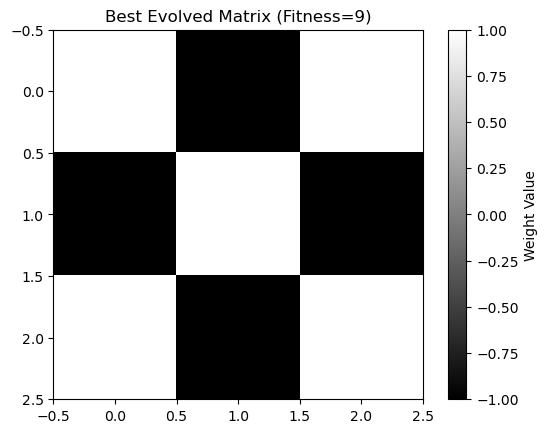

tensor([[ 1, -1,  1],
        [-1,  1, -1],
        [ 1, -1,  1]])


In [25]:
import torch
import random
import matplotlib.pyplot as plt

# Parameters
initial_population = 50
generations = 100
mutation_rate = 0.1
survivor =25



# --- Target ---
target_weight = torch.tensor([[1, -1, 1],
                              [-1, 1, -1],
                              [1, -1, 1]])

# --- Step 1: Initialize population ---
population = [generate_weight(3, 3) for _ in range(initial_population)]

# --- GA Loop ---
for gen in range(generations):
    # Step 2: Evaluate fitness
    fitness_scores = [get_fitness(target_weight, ind) for ind in population]
    
    # Step 3: Select best (elitism: keep top 2)
    sorted_pop = [p for _, p in sorted(zip(fitness_scores, population), key=lambda x: x[0], reverse=True)]
    best = sorted_pop[0]
    best_fitness = max(fitness_scores)
    
    print(f"Generation {gen}: Best fitness = {best_fitness}")
    
    # Stop early if perfect solution found
    if best_fitness == target_weight.numel():
        print("🎯 Found perfect match!")
        break
    
    # Step 4: Create next generation (mutations of top parents)
    new_population = []
    for i in range(initial_population):
        parent = random.choice(sorted_pop[:survivor]).clone()  # pick from top 5
        child = mutate_weight(parent.clone(), mutation_rate)
        new_population.append(child)
    
    population = new_population

# --- Show best solution ---
plt.imshow(best.numpy(), cmap="gray", interpolation="nearest")
plt.colorbar(label="Weight Value")
plt.title(f"Best Evolved Matrix (Fitness={best_fitness})")
plt.show()

print(best)

### 1.3.2 Multi channel

In [31]:
# Multi channel target (5 channel)
target_weight = torch.tensor([[[1, -1, 1],
                              [-1, 1, -1],
                              [1, -1, 1]],

                              [[1, -1, 1],
                              [1, -1, 1],
                              [1, -1, 1]],

                              [[1, 1, 1],
                              [-1, -1, -1],
                              [1, 1, 1]],

                              [[-1, 1, 1],
                              [1, -1, 1],
                              [1, 1, -1]],

                              [[1, 1, -1],
                              [1, -1, 1],
                              [-1, 1, 1]]
                            
                              ])

num_channel = target_weight.shape[0]
population  = 10

weight = [torch.stack([generate_weight(3, 3) for _ in range(num_channel)]) for _ in range(population)]

print(weight)





[tensor([[[ 1, -1, -1],
         [-1, -1,  1],
         [ 1,  1,  1]],

        [[-1, -1,  1],
         [ 1, -1, -1],
         [-1, -1,  1]],

        [[-1, -1, -1],
         [-1,  1, -1],
         [-1, -1, -1]],

        [[ 1, -1, -1],
         [-1, -1, -1],
         [-1,  1,  1]],

        [[-1, -1, -1],
         [-1,  1, -1],
         [-1,  1,  1]]]), tensor([[[-1, -1, -1],
         [-1, -1, -1],
         [-1,  1,  1]],

        [[-1,  1,  1],
         [-1,  1, -1],
         [-1,  1, -1]],

        [[-1,  1,  1],
         [ 1, -1, -1],
         [ 1,  1,  1]],

        [[-1, -1,  1],
         [ 1, -1,  1],
         [ 1, -1, -1]],

        [[ 1,  1, -1],
         [-1, -1,  1],
         [-1,  1,  1]]]), tensor([[[-1, -1,  1],
         [ 1,  1, -1],
         [-1,  1, -1]],

        [[ 1, -1,  1],
         [ 1,  1, -1],
         [ 1, -1, -1]],

        [[-1,  1, -1],
         [-1,  1, -1],
         [-1, -1, -1]],

        [[ 1,  1, -1],
         [-1,  1, -1],
         [-1,  1,  1]],

   

## 1.4 Creating VGG-16 binary code

Model params: 44426
Epoch 01  train_loss=0.8562 train_acc=0.7747  val_loss=0.3697 val_acc=0.8937  time=6.0s
Epoch 02  train_loss=0.3297 train_acc=0.9011  val_loss=0.2742 val_acc=0.9216  time=6.0s
Epoch 03  train_loss=0.2517 train_acc=0.9238  val_loss=0.1995 val_acc=0.9419  time=6.1s
Epoch 04  train_loss=0.2028 train_acc=0.9388  val_loss=0.1748 val_acc=0.9476  time=5.9s
Epoch 05  train_loss=0.1718 train_acc=0.9490  val_loss=0.1628 val_acc=0.9471  time=5.9s
Epoch 06  train_loss=0.1475 train_acc=0.9544  val_loss=0.1195 val_acc=0.9640  time=6.0s
Epoch 07  train_loss=0.1328 train_acc=0.9594  val_loss=0.1142 val_acc=0.9635  time=6.1s
Epoch 08  train_loss=0.1192 train_acc=0.9634  val_loss=0.1175 val_acc=0.9645  time=6.1s
Epoch 09  train_loss=0.1088 train_acc=0.9665  val_loss=0.0931 val_acc=0.9707  time=6.0s
Epoch 10  train_loss=0.0991 train_acc=0.9698  val_loss=0.0920 val_acc=0.9699  time=5.9s
Epoch 11  train_loss=0.0859 train_acc=0.9739  val_loss=0.0763 val_acc=0.9769  time=5.9s
Epoch 12  tr